Accuracy: 0.49


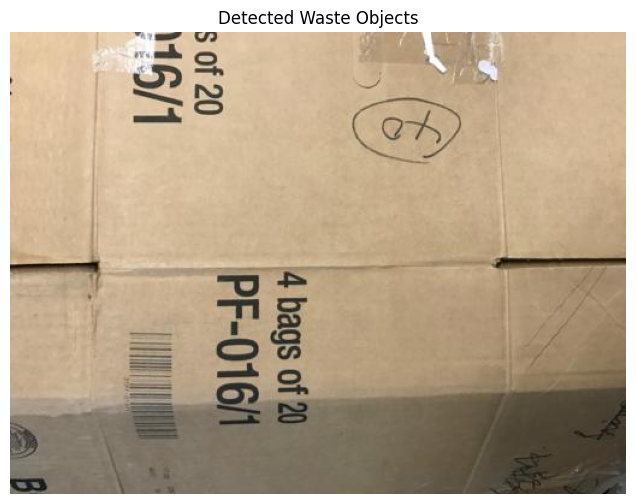

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def extract_color_features(roi):
    return np.mean(roi, axis=(0, 1))

def extract_shape_features(contour):
    if len(contour) < 5:
        return [0, 0, 0]  
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter != 0 else 0
    return [area, perimeter, circularity]

def extract_texture_features(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    return [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0],
    ]

def process_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return [], None, []
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 43, 46])
    upper_green = np.array([77, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features = []
    bounding_boxes = []
    for contour in contours:
        if cv2.contourArea(contour) > 100:
            x, y, w, h = cv2.boundingRect(contour)
            if w > 0 and h > 0:
                roi = img[y:y + h, x:x + w]
                color_features = extract_color_features(roi)
                shape_features = extract_shape_features(contour)
                texture_features = extract_texture_features(roi)
                combined_features = np.concatenate((color_features, shape_features, texture_features))
                features.append(combined_features)
                bounding_boxes.append((x, y, w, h))
    
    return features, img, bounding_boxes

def load_dataset(data_dir):
    features_list, labels_list = [], []
    for waste_type in os.listdir(data_dir):
        waste_path = os.path.join(data_dir, waste_type)
        if os.path.isdir(waste_path):
            for image_file in os.listdir(waste_path):
                image_path = os.path.join(waste_path, image_file)
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    features, _, _ = process_image(image_path)
                    for feature in features:
                        features_list.append(feature)
                        labels_list.append(waste_type)
    return features_list, labels_list

# Load dataset and train classifier
data_directory = "waste_dataset"
features, labels = load_dataset(data_directory)

if features:
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    test_image_path = "waste_dataset/cardboard/cardboard_003.jpg" 
    test_features, test_img, bounding_boxes = process_image(test_image_path)

    for i, feature in enumerate(test_features):
        prediction = clf.predict([feature.tolist()])
        x, y, w, h = bounding_boxes[i]
        label = prediction[0]
        print(label)
        # Draw bounding box and label
        cv2.rectangle(test_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(test_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Convert image from BGR to RGB for Jupyter display
    test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 6))
    plt.imshow(test_img_rgb)
    plt.axis("off")
    plt.title("Detected Waste Objects")
    plt.show()


In [31]:
import torch
import cv2
import matplotlib.pyplot as plt
import os
from ultralytics import YOLO

# Load the YOLOv8 model with your custom weights
model_path = r"weights/best.pt"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}")

model = YOLO(model_path)

# Load the image
image_path = r"waste_dataset/paper/paper_003.jpg"
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found at {image_path}")

image = cv2.imread(image_path)

# Run detection
results = model(image, conf=0.2)  # Lower confidence threshold

# Use YOLO's built-in result plotting
result_image = results[0].plot()  # Automatically draws detections

# Convert image to RGB for Matplotlib
image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Trash Detection Results")
plt.show()



0: 608x800 2 PAPERs, 213.0ms
Speed: 5.6ms preprocess, 213.0ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 800)


In [24]:
import torch
import cv2
import matplotlib.pyplot as plt
  # Ensure you are importing YOLOv5 correctly

# Load YOLOv5 model (Ensure you use the correct path)
model = torch.hub.load('yolov5', 'custom', path='taco2_epoch400_best.pt', force_reload=True)

# Load the image
image_path = "waste_dataset/paper/paper_002.jpg"
image = cv2.imread(image_path)

# Run inference (YOLOv5 expects a list of images)
results = model([image])

# Convert image to RGB for displaying
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Process and visualize results
for result in results.xyxy[0]:  # Accessing detection results
    x1, y1, x2, y2, conf, cls = map(int, result[:6])  # Extract values
    label = model.names[cls]  # Get class label

    # Draw bounding box and label
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, f"{label} {conf:.2f}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Trash Detection Results")
plt.show()


ValueError: not enough values to unpack (expected 2, got 1)